In [3]:
import operator
import random
import math
import copy
import matplotlib.pyplot as plt
from Cython import wraparound, boundscheck
import csv
import numpy as np
import pandas as pd
import cython.parallel as parallel

actual_theta = [0.7, 0.5, 0.4]

GREEDY_epsilon = [0.1, 0.5, 0.9]
UCB_c = [1, 5, 10]
TS_ab = [[[1, 1], [1, 1], [1, 1]],
         [[601, 401], [401, 601], [2, 3]]]

def data_generator(file_name):
    time = 10000
    def reward(choose):
        # choose: 1,2,3
        probability = actual_theta[choose - 1]
        if random.uniform(0, 1) < probability:
            return 1
        else:
            return 0

    with open(file_name, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow( ['arm1']+['arm2']+['arm3'])
        for t in range(time):
            r1 = reward(1)
            r2 = reward(2)
            r3 = reward(3)
            writer.writerow([r1] + [r2] + [r3])

class Loader:
    def __init__(self, path_train, path_test):
        self.train_data=None
        self.test_data=None
        self.table=None
        self.arm_num = None
        self.means=None
        self.optArm=None
        self.sampler=None
        self.range=None
        self.r_mid=None
        self.path_train=path_train
        self.path_test=path_test
        self.load_data(path_train,path_test)

    def load_data(self,path_train, path_test):
        self.train_data=pd.read_csv(path_train, low_memory=False)
        self.test_data=pd.read_csv(path_test, low_memory=False)
        if 'arm1' in self.train_data.columns.values:
            self.load_data_gen()
        else:
            self.load_data_movie()

    def load_data_gen(self):
        self.arm_num = self.train_data.columns.size
        self.range= self.train_data[self.train_data.columns[0]].max() - self.train_data[self.train_data.columns[0]].min()
        self.r_mid= float(self.train_data[self.train_data.columns[0]].max() + self.train_data[self.train_data.columns[0]].min()) / 2
        self.means = [0] * self.arm_num
        for i in range(self.arm_num):
            self.means[i] = self.test_data[self.test_data.columns[i]].mean()
        self.optArm = np.argmax(self.means)

        # 0,1,2,...
        self.table = np.zeros([self.arm_num, self.train_data.values.max() + 1, self.arm_num])
        for s_idx, source_arm in enumerate(self.train_data.columns):
            for a_idx, aim_arm in enumerate(self.train_data.columns):
                for i in range(self.train_data.values.max() + 1):
                    if source_arm == aim_arm:
                        self.table[s_idx][i][a_idx] = i
                    else:
                        p_reward = self.train_data[aim_arm][self.train_data[source_arm] == i].mean()
                        if p_reward > 1:
                            self.table[s_idx][i][a_idx] = 1
                        else:
                            self.table[s_idx][i][a_idx] = p_reward
        self.sampler=self.sample_gen

    def load_data_movie(self):
        #csv train_data
        self.arm_num = self.train_data['genre_col'].max() + 1
        self.range= self.train_data['Rating'].max() - self.train_data['Rating'].min()
        self.r_mid= float(self.train_data[self.train_data.columns[0]].max() + self.train_data[self.train_data.columns[0]].min()) / 2
        self.means=[0]*self.arm_num
        for i in range(self.arm_num):
            self.means[i]=self.test_data[self.test_data['genre_col'] == i]['Rating'].mean()
        self.optArm=np.argmax(self.means)
        #0,1,2,...
        self.table = np.zeros([self.arm_num, self.range + 1, self.arm_num])
        for source in range(self.arm_num):
            for score in range(self.train_data['Rating'].min(), self.train_data['Rating'].max() + 1):
                users=set(self.train_data[(self.train_data['genre_col'] == source) & (self.train_data['Rating'] == score)]['UserID'])
                self.table[source][:,source]=np.arange(self.train_data['Rating'].min(), self.train_data['Rating'].max() + 1)
                for aim in range(self.arm_num):
                    if aim==source:
                        continue
                    temp=self.train_data[(self.train_data['genre_col'] == aim) & (self.train_data['UserID'].isin(users))]['Rating']
                    self.table[source][score - self.train_data['Rating'].min()][aim]=temp.mean()
        self.sampler =self.sample_movie

    def sample_movie(self,choose):
        v= self.test_data[self.test_data['genre_col'] == choose]['Rating'].sample(n=1, replace=True)
        return v.values[0]

    def sample_gen(self, choose):
        reward = self.test_data[self.test_data.columns[choose]].sample(n=1, replace=True)
        return reward.values[0]

class P1:

    def __init__(self, depend_data_path_train=None,depend_data_path_test=None):
        self.path = depend_data_path_test
        self.greedy_regret = np.zeros(N+1)
        self.TS_regret = np.zeros(N+1)
        self.UCB_regret = np.zeros(N+1)
        self.dependent_UCB_regret = np.zeros(N+1)
        self.dependent_TS_regret = np.zeros(N+1)
        self.TS_Gauss_regret=np.zeros(N+1)

        if depend_data_path_test is not None:
            self.loader=Loader(depend_data_path_train, depend_data_path_test)
            self.actual_theta=self.loader.means
            self.optArm=self.loader.optArm
            self.arm_num=self.loader.arm_num
            self.sampler=self.loader.sampler
            self.table=self.loader.table
            self.range=self.loader.range
            self.r_mid=self.loader.r_mid
        else:
            self.loader=None
            self.table=None
            self.range = 1
            self.r_mid=0.5
            self.actual_theta=actual_theta
            self.optArm=np.argmax(self.actual_theta)
            self.arm_num = len(self.actual_theta)
            self.sampler=self.independ_reward

    def independ_reward(self, choose):
        # choose: 1,2,3
        probability = self.actual_theta[choose]
        if random.uniform(0, 1) < probability:
            return 1
        else:
            return 0

    def e_Greedy(self, N, epsilon):
        # initialize
        # Notice we set index start from 1
        theta = [0]*self.arm_num
        count =[0]*self.arm_num
        total_reward = 0
        greedy_current_regret = np.zeros(N+1)

        for t in range(N):
            # I_t=1,2,3...
            if random.uniform(0, 1) < epsilon:
                I_t = random.randint(0, self.arm_num-1)
            else:
                I_t = np.argmax(theta)

            count[I_t] += 1
            r = self.sampler(I_t)
            total_reward += r
            theta[I_t] += (1 / count[I_t]) * (r - theta[I_t])
            if t==0:
                greedy_current_regret[t+1] = self.actual_theta[self.optArm] - self.actual_theta[I_t]
            else:
                greedy_current_regret[t+1] = greedy_current_regret[t] + self.actual_theta[self.optArm] - self.actual_theta[I_t]

        self.greedy_regret += greedy_current_regret
        return total_reward

    def Ucb(self, N, c):
        # note the index start from 0
        count = [0]* self.arm_num
        theta = [0]* self.arm_num
        total_reward = 0
        UCB_current_regret = np.zeros(N+1)

        # initialize
        for t in range(self.arm_num):
            I_t = t
            count[I_t] = 1
            theta[I_t] = self.sampler(I_t)
            if t==0:
                UCB_current_regret[t+1] = self.actual_theta[self.optArm] - self.actual_theta[I_t]
            else:
                UCB_current_regret[t+1] = UCB_current_regret[t] + self.actual_theta[self.optArm] - self.actual_theta[I_t]

        for t in range(self.arm_num, N):
            # select and pull arm
            I_t =np.argmax([theta[j] + c * math.sqrt(2 * math.log(t) / count[j]) for j in range(self.arm_num)])

            count[I_t] += 1
            r = self.sampler(I_t)
            total_reward += r
            theta[I_t] += (r - theta[I_t]) / count[I_t]
            UCB_current_regret[t+1] = UCB_current_regret[t] + self.actual_theta[self.optArm] - self.actual_theta[I_t]

        self.UCB_regret += UCB_current_regret
        return total_reward

    def depend_Ucb(self, N, c):
        table=self.table
        arm_num=self.arm_num

        count = np.array([0]*arm_num)
        theta = np.array([0.]*arm_num)
        ucb_idx=dict(zip(range(arm_num),[np.inf]*arm_num))
        ave_pseudo_reward=np.array([[np.inf]*arm_num]*arm_num)
        sum_pseudo_reward=np.array([[0.]*arm_num]*arm_num)
        d_UCB_current_regret = np.zeros(N+1)

        total_reward = 0
        for t in range(N):
            if t<arm_num:
                choose=t
            else:
                S_bool=(count>=(float(t-1)/arm_num))
                k_emp_reward=np.max(theta[S_bool])
                k_emp=np.where(theta==k_emp_reward)[0][0]
                comp_set=set()
                comp_set.add(k_emp)
                min_phi = np.min(ave_pseudo_reward[:, S_bool], axis=1)
                for k in range(arm_num):
                    if min_phi[k]>= k_emp_reward:
                        comp_set.add(k)

                comp_idx={ind: ucb_idx[ind] for ind in comp_set}
                choose=max(comp_idx.items(),key=operator.itemgetter(1))[0]
            # print(t,choose)
            if t==0:
                d_UCB_current_regret[t+1] = self.actual_theta[self.optArm] - self.actual_theta[choose]
            else:
                d_UCB_current_regret[t+1] = d_UCB_current_regret[t] + self.actual_theta[self.optArm] - self.actual_theta[choose]

            reward=self.sampler(choose)
            count[choose]+=1
            theta[choose]+=((reward-theta[choose])/count[choose])

            for arm in range(arm_num):
                if (count[arm] > 0):
                    ucb_idx[arm] = theta[arm] + c * np.sqrt(2 * np.log(t + 1) / count[arm])

            # pseudoReward=table[choose][reward]
            pseudoReward = table[choose][reward - 1,:]
            sum_pseudo_reward[:, choose] = sum_pseudo_reward[:, choose]+ pseudoReward
            ave_pseudo_reward[:, choose] = np.divide(sum_pseudo_reward[:, choose], count[choose])

            ave_pseudo_reward[np.arange(arm_num),np.arange(arm_num)]=theta

            total_reward+=reward

        self.dependent_UCB_regret += d_UCB_current_regret
        return total_reward

    def TS_sample_Gauss(self,theta,count,beta):
        std=np.sqrt(float(beta)/(count+1))
        return np.random.normal(theta,std)


    def TS_arm_choose_beta(self, ab):
        theta = [0 for i in ab]
        for i, (a, b) in enumerate(ab):
            theta[i] = np.random.beta(a, b)
        return np.argmax(theta)

    def TS(self, N, ab_original):

        total_reward = 0
        # ab idx start from 0
        ab = copy.deepcopy(ab_original)
        TS_current_regret = np.zeros(N+1)
        for t in range(N):
            I_t = self.TS_arm_choose_beta(ab)
            # print(I_t)
            # update distribution
            r = self.sampler(I_t)
            ab[I_t][0] += r
            ab[I_t][1] += (1 - r)
            total_reward += r
            if t==0:
                TS_current_regret[t+1] = self.actual_theta[self.optArm] - self.actual_theta[I_t]
            else:
                TS_current_regret[t+1] = TS_current_regret[t] + self.actual_theta[self.optArm] - self.actual_theta[I_t]
        # compute the expectation!!
        # result = []
        # for j in arms:
        #     result.append(ab[j - 1][0] / (ab[j - 1][0] + ab[j - 1][1]))
        # print(choose_first_cluster)

        self.TS_regret += TS_current_regret
        return total_reward

    def TS_Gauss(self, N, beta):
        arm_num=self.arm_num
        total_reward = 0
        # ab idx start from 0
        TS_G_current_regret = np.zeros(N + 1)
        theta = np.array([self.r_mid] * arm_num)
        count = np.array([0] * arm_num)
        for t in range(N):
            I_t=np.argmax(self.TS_sample_Gauss(theta,count,beta))
            # print(I_t)
            # update distribution
            r = self.sampler(I_t)
            count[I_t] += 1
            theta[I_t] += ((r - theta[I_t]) / count[I_t])
            total_reward += r
            if t==0:
                TS_G_current_regret[t+1] = self.actual_theta[self.optArm] - self.actual_theta[I_t]
            else:
                TS_G_current_regret[t+1] = TS_G_current_regret[t] + self.actual_theta[self.optArm] - self.actual_theta[I_t]
        # compute the expectation!!
        # result = []
        # for j in arms:
        #     result.append(ab[j - 1][0] / (ab[j - 1][0] + ab[j - 1][1]))
        # print(choose_first_cluster)

        self.TS_Gauss_regret += TS_G_current_regret
        return total_reward

    # TODO
    def depend_TS(self, N, beta):
        table = self.table
        arm_num = self.arm_num

        theta = np.array([self.r_mid] * arm_num)
        count = np.array([0] * arm_num)

        ave_pseudo_reward = np.array([[np.inf] * arm_num] * arm_num)
        sum_pseudo_reward = np.array([[0.] * arm_num] * arm_num)
        d_TS_current_regret = np.zeros(N + 1)

        total_reward = 0
        for t in range(N):
            if t<arm_num:
                choose=t
            else:
                S_bool = (count >= (float(t - 1) / arm_num))

                k_emp_reward = np.max(theta[S_bool])
                k_emp = np.where(theta == k_emp_reward)[0][0]
                comp_set = set()
                comp_set.add(k_emp)
                min_phi = np.min(ave_pseudo_reward[:, S_bool], axis=1)
                for k in range(arm_num):
                    if min_phi[k] >= k_emp_reward:
                        comp_set.add(k)

                sample=self.TS_sample_Gauss(theta,count,beta)
                comp_idx = {ind: sample[ind] for ind in comp_set}
                choose = max(comp_idx.items(), key=operator.itemgetter(1))[0]
            # print(t,choose)
            if t == 0:
                d_TS_current_regret[t + 1] = self.actual_theta[self.optArm] - self.actual_theta[choose]
            else:
                d_TS_current_regret[t + 1] = d_TS_current_regret[t] + self.actual_theta[self.optArm] - \
                                              self.actual_theta[choose]

            reward = self.sampler(choose)
            count[choose] += 1
            theta[choose] += ((reward - theta[choose]) / count[choose])

            # pseudoReward=table[choose][reward]
            pseudoReward = table[choose][reward - 1, :]
            sum_pseudo_reward[:, choose] = sum_pseudo_reward[:, choose] + pseudoReward
            ave_pseudo_reward[:, choose] = np.divide(sum_pseudo_reward[:, choose], count[choose])

            ave_pseudo_reward[np.arange(arm_num), np.arange(arm_num)] = theta

            total_reward += reward

        self.dependent_TS_regret += d_TS_current_regret
        return total_reward

    @boundscheck(False)
    @wraparound(False)
    def result(self, function_idx):
        function = ['epsilon-greedy', 'UCB', 'TS', 'D-UCB','TS-Gauss', 'D-TS']
        print("results for", function[function_idx - 1], "Algorithm:")
        para = []
        func = None

        if function_idx == 1:
            para = GREEDY_epsilon
            func = self.e_Greedy
            parameter = "epsilon"
            regret=self.greedy_regret
        elif function_idx == 2:
            para = UCB_c
            func = self.Ucb
            parameter = "c"
            regret=self.UCB_regret
        elif function_idx == 3:
            para = TS_ab
            func = self.TS
            parameter = "a,b"
            regret=self.TS_regret
        elif function_idx == 4:
            para = UCB_c
            func = self.depend_Ucb
            parameter = "c"
            regret=self.dependent_UCB_regret
        elif function_idx == 5:
            para = [self.range/2]
            func = self.TS_Gauss
            parameter = "Beta"
            regret=self.TS_Gauss_regret
        elif function_idx == 6:
            para = [self.range/2]
            func = self.depend_TS
            parameter = "Beta"
            regret=self.dependent_TS_regret

        regret.fill(0.)
        for p in para:
            result = 0.0
            for trial in parallel.prange(trial_times, nogil=True,schedule="static"):
                result += func(N, p)
            result /= trial_times
            print(result, "with parameter", parameter, "as", p)
        regret /= (trial_times * len(para))
        

In [4]:
print("Independent part")
trial_times = 200
N = 5000
p1=P1()
p1.result(1)
p1.result(2)
p1.result(3)

Independent part
results for epsilon-greedy Algorithm:
3413.155 with parameter epsilon as 0.1
3079.215 with parameter epsilon as 0.5
2751.625 with parameter epsilon as 0.9
results for UCB Algorithm:
3412.35 with parameter c as 1
2978.915 with parameter c as 5
2829.74 with parameter c as 10
results for TS Algorithm:
3481.24 with parameter a,b as [[1, 1], [1, 1], [1, 1]]
3489.785 with parameter a,b as [[601, 401], [401, 601], [2, 3]]


In [13]:
print("Independent part")
print("Exploration-Exploitation trade-off control group")
trial_times = 200
N = 5000
actual_theta = [0.5, 0.7, 0.9]
GREEDY_epsilon = [0.005, 0.1]
UCB_c = [0.1, 1]
TS_ab = [[[1, 1], [1, 1], [1, 1]],
         [[701, 301], [601, 401], [2, 3]]]
p1=P1()
p1.result(1)
p1.result(2)
p1.result(3)

Independent part
Exploration-Exploitation trade-off control group
results for epsilon-greedy Algorithm:
4213.31 with parameter epsilon as 0.005
4388.64 with parameter epsilon as 0.1
results for UCB Algorithm:
4358.77 with parameter c as 0.1
4415.93 with parameter c as 1
results for TS Algorithm:
4490.565 with parameter a,b as [[1, 1], [1, 1], [1, 1]]
4481.905 with parameter a,b as [[701, 301], [601, 401], [2, 3]]


In [5]:
print("Dependent part")
print("computer generated data")
# data_generator('dependent_data.csv')
GREEDY_epsilon = [0.1]
UCB_c = [1]
TS_ab = [[[601, 401], [401, 601], [2, 3]]]
trial_times = 50
N = 1000

p1_d1=P1('dependent_data_train.csv','dependent_data.csv')
p1_d1.result(1)
p1_d1.result(2)
p1_d1.result(3)
p1_d1.result(4)
p1_d1.result(5)
p1_d1.result(6)

Dependent part
computer generated data
results for epsilon-greedy Algorithm:
685.8 with parameter epsilon as 0.1
results for UCB Algorithm:
658.8 with parameter c as 1
results for TS Algorithm:
697.82 with parameter a,b as [[601, 401], [401, 601], [2, 3]]
results for D-UCB Algorithm:
704.82 with parameter c as 1
results for TS-Gauss Algorithm:
685.44 with parameter Beta as 0.5
results for D-TS Algorithm:
704.6 with parameter Beta as 0.5


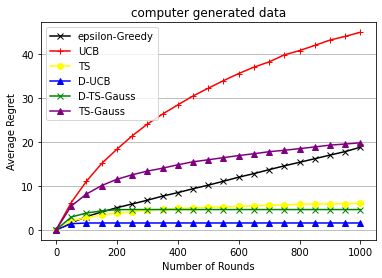

In [6]:
# plot
spacing = int(N/20)
plt.plot(range(0, N+1)[::spacing], p1_d1.greedy_regret[::spacing], label='epsilon-Greedy', color='black', marker='x')
plt.plot(range(0, N+1)[::spacing], p1_d1.UCB_regret[::spacing], label='UCB', color='red', marker='+')
plt.plot(range(0, N+1)[::spacing], p1_d1.TS_regret[::spacing], label='TS', color='yellow', marker='o')
plt.plot(range(0, N+1)[::spacing], p1_d1.dependent_UCB_regret[::spacing], label='D-UCB', color='blue', marker='^')
plt.plot(range(0, N+1)[::spacing], p1_d1.dependent_TS_regret[::spacing], label='D-TS-Gauss', color='green', marker='x')
plt.plot(range(0, N+1)[::spacing], p1_d1.TS_Gauss_regret[::spacing], label='TS-Gauss', color='purple', marker='^')
plt.legend()
plt.grid(True, axis='y')
plt.xlabel('Number of Rounds')
plt.ylabel('Average Regret')
plt.title("computer generated data")
plt.show()

In [11]:
print("Dependent part")
print("three movie data")
GREEDY_epsilon = [0.1]
UCB_c = [1]
TS_ab = [[[601, 401], [401, 601], [2, 3]]]
trial_times = 50
N = 5000
p1_d2 = P1('movie_3_train.csv','movie_3.csv')

p1_d2.result(1)
p1_d2.result(2)
# p1_d2.result(3)
p1_d2.result(4)
p1_d2.result(5)
p1_d2.result(6)

Dependent part
three movie data
results for epsilon-greedy Algorithm:
18231.34 with parameter epsilon as 0.1
results for UCB Algorithm:
18265.6 with parameter c as 1
results for D-UCB Algorithm:
18286.58 with parameter c as 1
results for TS-Gauss Algorithm:
18255.18 with parameter Beta as 2.0
results for D-TS Algorithm:
18279.9 with parameter Beta as 2.0


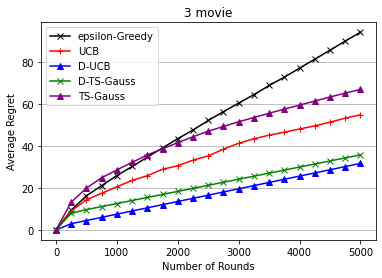

In [12]:
# plot
spacing = int(N/20)
plt.plot(range(0, N+1)[::spacing], p1_d2.greedy_regret[::spacing], label='epsilon-Greedy', color='black', marker='x')
plt.plot(range(0, N+1)[::spacing], p1_d2.UCB_regret[::spacing], label='UCB', color='red', marker='+')
# plt.plot(range(0, N+1)[::spacing], p1_d2.TS_regret[::spacing], label='TS', color='yellow', marker='o')
plt.plot(range(0, N+1)[::spacing], p1_d2.dependent_UCB_regret[::spacing], label='D-UCB', color='blue', marker='^')
plt.plot(range(0, N+1)[::spacing], p1_d2.dependent_TS_regret[::spacing], label='D-TS-Gauss', color='green', marker='x')
plt.plot(range(0, N+1)[::spacing], p1_d2.TS_Gauss_regret[::spacing], label='TS-Gauss', color='purple', marker='^')
plt.legend()
plt.grid(True, axis='y')
plt.xlabel('Number of Rounds')
plt.ylabel('Average Regret')
plt.title("3 movie")
plt.show()

In [9]:
print("Dependent part")
print("18 movie data")
GREEDY_epsilon = [0.1]
UCB_c = [1]
TS_ab = [[[601, 401], [401, 601], [2, 3]]]
trial_times = 50
N = 1000

p1_d3 = P1('movie_18_train.csv','movie_18.csv')
p1_d3.result(1)
p1_d3.result(2)
# p1_d3.result(3)
p1_d3.result(4)
p1_d3.result(5)
p1_d3.result(6)

Dependent part
18 movie data
results for epsilon-greedy Algorithm:
4077.76 with parameter epsilon as 0.1
results for UCB Algorithm:
3927.14 with parameter c as 1
results for D-UCB Algorithm:
4181.4 with parameter c as 1
results for TS-Gauss Algorithm:
3958.7 with parameter Beta as 2.0
results for D-TS Algorithm:
4185.76 with parameter Beta as 2.0


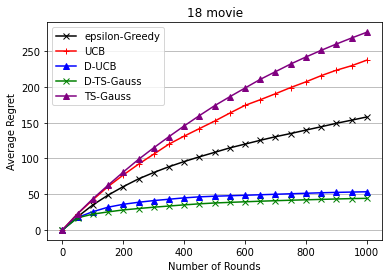

In [10]:
# plot
spacing = int(N/20)
plt.plot(range(0, N+1)[::spacing], p1_d3.greedy_regret[::spacing], label='epsilon-Greedy', color='black', marker='x')
plt.plot(range(0, N+1)[::spacing], p1_d3.UCB_regret[::spacing], label='UCB', color='red', marker='+')
# plt.plot(range(0, N+1)[::spacing], p1_d3.TS_regret[::spacing], label='TS', color='yellow', marker='o')
plt.plot(range(0, N+1)[::spacing], p1_d3.dependent_UCB_regret[::spacing], label='D-UCB', color='blue', marker='^')
plt.plot(range(0, N+1)[::spacing], p1_d3.dependent_TS_regret[::spacing], label='D-TS-Gauss', color='green', marker='x')
plt.plot(range(0, N+1)[::spacing], p1_d3.TS_Gauss_regret[::spacing], label='TS-Gauss', color='purple', marker='^')
plt.legend()
plt.grid(True, axis='y')
plt.xlabel('Number of Rounds')
plt.ylabel('Average Regret')
plt.title("18 movie")
plt.show()